##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Semantic Dictionaries -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

This notebook studies **semantic dictionaries**. The basic idea of semantic dictionaries is to marry neuron activations to visualizations of those neurons, transforming them from abstract vectors to something more meaningful to humans. Semantic dictionaries can also be applied to other bases, such as rotated versions of activations space that try to disentangle neurons.

<br>
<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/semantic-dictionary.jpeg" width="648"></img>
<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [2]:
# !pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git
# !npm install -g svelte-cli@2.2.0
# %tensorflow_version 1.x

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

# Semantic Dictionary Code

## **Defining the interface**

First, we define our "semantic dictionary" interface as a [svelte component](https://svelte.technology/). This makes it easy to manage state, like which position we're looking at.

In [3]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};">
            </div>
            <div style="display: inline-block;width: 32px;">
                <div style="bottom: {{sprite_size*act.v/1000.0}}px;">{{Math.round(act.v*100)/100}}</div>
                <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
            </div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_ae67hzla/SemanticDict_b3405b79_742c_4b9b_9aba_c16fbcd2ead8.html > /tmp/svelte_ae67hzla/SemanticDict_b3405b79_742c_4b9b_9aba_c16fbcd2ead8.js
b'svelte version 1.64.1\ncompiling ../../../../../../tmp/svelte_ae67hzla/SemanticDict_b3405b79_742c_4b9b_9aba_c16fbcd2ead8.html...\n'



## **Spritemaps**

In order to use the semantic dictionaries, we need "spritemaps" of channel visualizations.
These visualization spritemaps are large grids of images (such as [this one](https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_mixed4d_channel.jpeg)) that visualize every channel in a layer.
We provide spritemaps for GoogLeNet because making them takes a few hours of GPU time, but
you can make your own channel spritemaps to explore other models. [Check out other notebooks](https://github.com/tensorflow/lucid#notebooks) on how to
make your own neuron visualizations.

It's also worth noting that GoogLeNet has unusually semantically meaningful neurons. We don't know why this is -- although it's an active area of research for us. More sophisticated interfaces, such as neuron groups, may work better for networks where meaningful ideas are more entangled or less aligned with the neuron directions.

In [4]:
layer_spritemap_sizes = {
    'mixed3a' : 16,
    'mixed3b' : 21,
    'mixed4a' : 22,
    'mixed4b' : 22,
    'mixed4c' : 22,
    'mixed4d' : 22,
    'mixed4e' : 28,
    'mixed5a' : 28,
  }

def googlenet_spritemap(layer):
    assert layer in layer_spritemap_sizes
    size = layer_spritemap_sizes[layer]
    url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_%s_channel_alpha.jpeg" % layer
    return size, url

## **User facing constructor**

Now we'll create a convenient API for creating semantic dictionary visualizations. It will compute the network activations for an image, grab an appropriate spritemap, and render the interface.

In [5]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()


def googlenet_semantic_dict(layer, img_url):
    img = load(img_url)
    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [224, 224, 3])
        T = render.import_model(googlenet, t_input, t_input)
        acts = T(layer).eval({t_input: img})[0]
    
    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = int(np.argmax(max_mag.max(-1)))
    max_y = int(np.argmax(max_mag[max_x]))
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = googlenet_spritemap(layer)
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 110,
        "sprite_n_wrap": spritemap_n, # row size
        "image_url": _image_url(img), # generate a data:image/ url
        "activations": [
            [
                [{"n": int(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]]
                for act_vec in act_slice
            ]
            for act_slice in acts
        ], # the 4 features with the highest activation for the tile
        "pos": [max_y, max_x], # best position for initial view
    })
    
    

# Now let's make some semantic dictionaries!


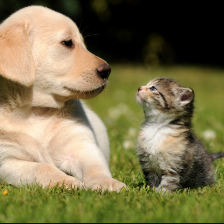

In [6]:
googlenet_semantic_dict("mixed4d", "https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")


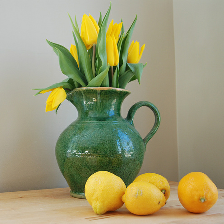

In [7]:
googlenet_semantic_dict("mixed4d", "https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png")